# Testing setBLP.jl

## Packages

In [1]:
import LinearAlgebra ,Base

In [2]:
using Plots

## Structures and related functions

#### Vertex

In [3]:
mutable struct Vertex
    v::Vector{Real}
end

In [4]:
function subVertex(v1::Vertex,v2::Vertex)
    return  Vertex(v1.v-v2.v)
end

Base.:(-)(v1::Vertex,v2::Vertex) = Vertex(v1.v-v2.v)

function addVertex(v1::Vertex,v2::Vertex)
    return Vertex(v1.v+v2.v)
end

Base.:(+)(v1::Vertex,v2::Vertex) = Vertex(v1.v+v2.v)

In [5]:
function xangle(p1::Vertex,p2::Vertex)
    Δ = (p2-p1).v
    flag=false
    if Δ[2] < 0
        Δ[2] = -Δ[2]
        flag = true
    end
    xang =atan(Δ[2],abs(Δ[1]))
    if Δ[1]<0
        xang = pi-xang
    end
    if flag
        xang=2*pi-xang
    end
    return xang

end

xangle (generic function with 1 method)

In [6]:
function fetchY(ver::Vertex)
    return ver.v[2]
end

function fetchX(ver::Vertex)
    return ver.v[1]
end

fetchX (generic function with 1 method)

#### Segment

In [7]:
mutable struct Segment
    p1::Vertex
    p2::Vertex
    checkInput::Function
    length::Function
    dim::Function

    
    function Segment(p1,p2)
        this = new()

        this.p1 = p1
        this.p2 = p2

        this.checkInput = function()
            return size(this.p1) == size(this.p2)       
        end

        this.length = function()
            return norm(this.p1-this.p2)
        end

        this.dim = function()
            if this.checkInput()
                return length(this.p1)
            else
                return false
            end
        end

        return this        
    end
end


In [8]:
function dotDist(p::Vector{<:Real}, segment::Segment) 
    if segment.checkInput()
        if length(p) == segment.dim()
            p1_p2 = segment.p1 -segment.p2
            p_p2 = p -segment.p2

            λ = dot(p1_p2,p_p2)/dot(p1_p2,p1_p2)
            λ = max(min(λ,1),0)

            p0 = λ*segment.p1 + (1-λ)*segment.p2 

            return norm(p-p0)
        else
            return "dimention of p doesnt match dimention of segment"
        end
    else
        return "Segment has wrong dimentions"
    end
end


dotDist (generic function with 1 method)

In [9]:
function xangle(seg::Segment)
    Δ = seg.p2-seg.p1
    flag=false
    if Δ[2] < 0
        Δ[2] = -Δ[2]
        flag = true
    end
    xang =atan(Δ[2],abs(Δ[1]))
    if Δ[1]<0
        xang = pi-xang
    end
    if flag
        xang=2*pi-xang
    end
    return xang

end

xangle (generic function with 2 methods)

#### Polygon

In [10]:
mutable struct Polygon
    vertices :: Vector{Vertex}
    sort :: Function
    plot :: Function
    angles :: Function
    scatter :: Function

    function Polygon(vertices)
        this = new()

        this.vertices=vertices
        this.sort = function()
            n=length(this.vertices)
            #step 1: find the point with a minimal y coordinate and put it first.
            # comment: sorting is complexity nlog(n) but the following is just n
            #using sorting:
            #I = sortperm(fetchY.(this.vertices))
            #this.vertices = this.vertices[I]
            #going over the list
            m=fetchY(this.vertices[1])
            for i=2:n
                l=fetchY(this.vertices[i])
                if l<m #then swap
                    m=l
                    temp=this.vertices[i]
                    this.vertices[i]=this.vertices[1]
                    this.vertices[1]=temp
                end
            end
            #step 2: compute angles between the minimal vertex and all other vertices
            angs =zeros(n) #first column for angles and second column for the x coordinate
            angs[1]=-1
            v1 =this.vertices[1]
            for i=2:n
                angs[i] = xangle(v1,this.vertices[i])
            end
            #step 3: sort by angle
            I=sortperm(angs)
            this.vertices=this.vertices[I]   
        end
        this.angles = function()
            n=length(this.vertices)
            ang=zeros(n)
            for i=1:n
                i==n ? j=1 : j=i+1
                ang[i] =xangle(this.vertices[i],this.vertices[j])                
            end
            return ang
        end
        
        this.plot = function()
            n=length(this.vertices)
            x=zeros(n+1); y=zeros(n+1);
            for i=1:n
                x[i]=this.vertices[i].v[1]
                y[i]=this.vertices[i].v[2]
            end
            x[n+1]=this.vertices[1].v[1]
            y[n+1]=this.vertices[1].v[2]
            plot(x,y,label="",fill=true)
        end
        
        this.scatter = function()
            n=length(this.vertices)
            x=zeros(n); y=zeros(n);
            for i=1:n
                x[i]=this.vertices[i].v[1]
                y[i]=this.vertices[i].v[2]
            end
            scatter(x,y,label="")
        end
            
        return this
    end
end

In [11]:
function minkowskiSum(v::Vertex,P::Polygon)
    # this function adds v toevery vertex of P
    n=length(P.vertices)
    R=P #initial value
    for i=1:n
        R.vertices[i] +=v
    end
    return R
end

Base.:(+)(v::Vertex,P::Polygon) = minkowskiSum(v,P)

In [28]:
function minkowskiSum(P::Polygon,Q::Polygon)
    # Computes the minkowski sum of two convex polygons: P and Q. The polygons
    # are represented by their vertices and are ordered counter clockwise such
    #* that the first vertex will be the one who has the smallest Y coordinate
    # (and smallest X coordinate in case of a tie).  This assumption is maintained
    # in twoDproj by conditions in BLPcalculator.
    
      
    angP=[P.angles(); 100]
    angQ=[Q.angles(); 100]
    
    m = length(angP)
    n = length(angQ)
    
    PP = [P.vertices; P.vertices[1]]
    QQ = [Q.vertices; Q.vertices[1]]
    
    println("m=",m," n=",n)
    
    println("angP= ", angP)
    println("angQ= ", angQ)
    
    i=1; j=1;
    println("----- begin ----------")
    
    R =Polygon([PP[1]+QQ[1]]) # a polygon with the sum of the two lower points as the first vertex.
    println("R vertices: ",R.vertices)
    while (i<m || j<n)
         if angP[i]<angQ[j] 
            println("angP[i] is minimal")
            i +=1
        elseif angQ[j]<angP[i]
            println("angQ[j] is minimal")
            j +=1
        else
            i +=1
            j +=1
        end
        R.vertices = [ R.vertices; PP[i]+QQ[j]]
        println(i,j)
        println("R vertices: ",R.vertices)
    end
    return R
end

Base.:(+)(P::Polygon,Q::Polygon) = minkowskiSum(P,Q)

## Testing

In [13]:
v4=Vertex([0,0.4])
v2=Vertex([-1.1,0])
v3=Vertex([1.1,0])
v1=Vertex([0.0,-0.6])
P = Polygon([v1,v2,v3,v4])
#P = Polygon([v1,v2,v3])

Polygon(Vertex[Vertex(Real[0.0, -0.6]), Vertex(Real[-1.1, 0.0]), Vertex(Real[1.1, 0.0]), Vertex(Real[0.0, 0.4])], var"#7#11"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#9#13"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#8#12"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#10#14"{Polygon}(Polygon(#= circular reference @-2 =#)))

[0.49934672168013006, 2.792821650005886, 3.4903636571737002, 5.783838585499456]

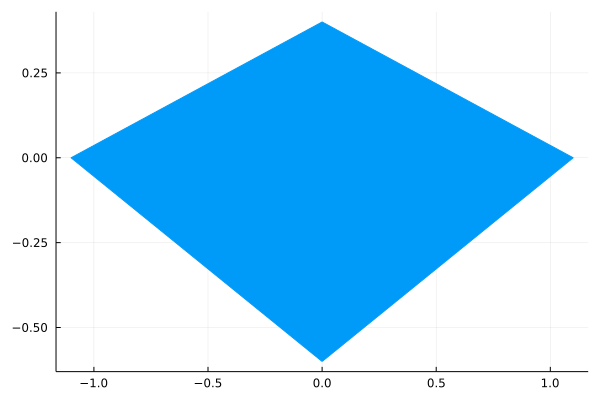

In [14]:
P.sort();
print(P.angles())
P.plot()

In [32]:
u4=Vertex([-1,0])
u2=Vertex([1,0.1])
u3=Vertex([-1,0.55])
u1=Vertex([1.1,0.5])
u5=Vertex([0.1,1.1])
Q = Polygon([u1,u2,u3,u4,u5])
#Q = Polygon([u1,u2,u4,])

Polygon(Vertex[Vertex(Real[1.1, 0.5]), Vertex(Real[1.0, 0.1]), Vertex(Real[-1.0, 0.55]), Vertex(Real[-1, 0]), Vertex(Real[0.1, 1.1])], var"#7#11"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#9#13"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#8#12"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#10#14"{Polygon}(Polygon(#= circular reference @-2 =#)))

[0.049958395721942765, 1.3258176636680323, 2.601173153319209, 3.6052402625905993, 4.71238898038469]

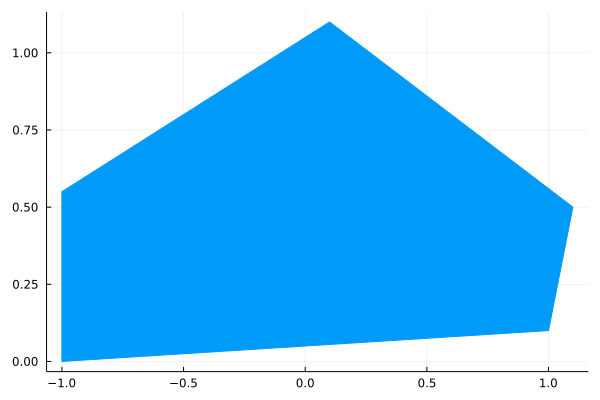

In [33]:
Q.sort();
print(Q.angles())
Q.plot()

In [34]:
R=minkowskiSum(P,Q)
#print(R.angles())

m=5 n=6
angP= [0.49934672168013006, 2.792821650005886, 3.4903636571737002, 5.783838585499456, 100.0]
angQ= [0.049958395721942765, 1.3258176636680323, 2.601173153319209, 3.6052402625905993, 4.71238898038469, 100.0]
----- begin ----------
R vertices: Vertex[Vertex(Real[0.10000000000000009, -0.09999999999999998])]
angQ[j] is minimal
12
R vertices: Vertex[Vertex(Real[0.10000000000000009, -0.09999999999999998]), Vertex(Real[2.1, 2.7755575615628914e-17])]
angP[i] is minimal
22
R vertices: Vertex[Vertex(Real[0.10000000000000009, -0.09999999999999998]), Vertex(Real[2.1, 2.7755575615628914e-17]), Vertex(Real[3.2, 0.6])]
angQ[j] is minimal
23
R vertices: Vertex[Vertex(Real[0.10000000000000009, -0.09999999999999998]), Vertex(Real[2.1, 2.7755575615628914e-17]), Vertex(Real[3.2, 0.6]), Vertex(Real[3.3000000000000003, 1.0])]
angQ[j] is minimal
24
R vertices: Vertex[Vertex(Real[0.10000000000000009, -0.09999999999999998]), Vertex(Real[2.1, 2.7755575615628914e-17]), Vertex(Real[3.2, 0.6]), Vertex(Real[

Polygon(Vertex[Vertex(Real[0.10000000000000009, -0.09999999999999998]), Vertex(Real[2.1, 2.7755575615628914e-17]), Vertex(Real[3.2, 0.6]), Vertex(Real[3.3000000000000003, 1.0]), Vertex(Real[2.3000000000000003, 1.6]), Vertex(Real[1.2000000000000002, 2.0]), Vertex(Real[0.1, 1.6]), Vertex(Real[-1.0, 1.05]), Vertex(Real[-1.0, 0.5]), Vertex(Real[0.10000000000000009, -0.09999999999999998])], var"#7#11"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#9#13"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#8#12"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#10#14"{Polygon}(Polygon(#= circular reference @-2 =#)))

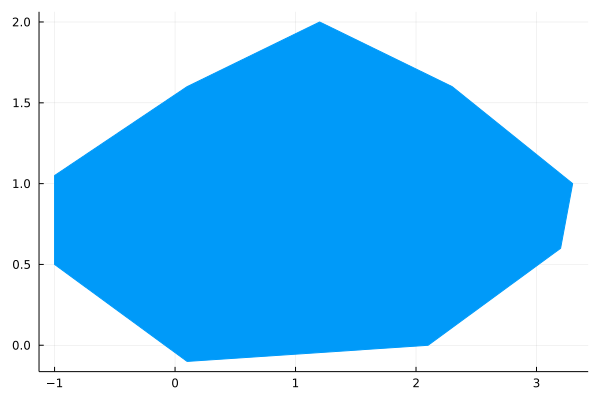

In [35]:
R.sort();
R.plot()

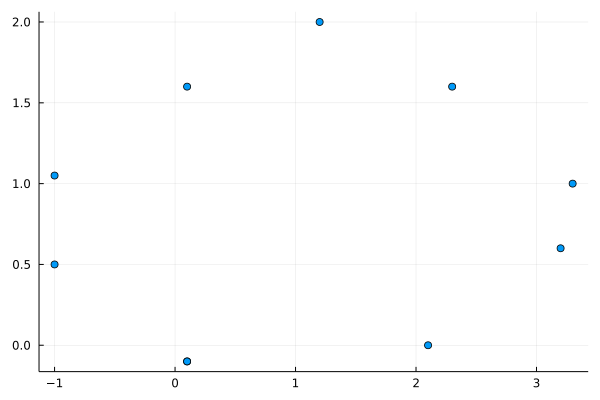

In [36]:
R.scatter()

In [37]:
R.angles()

10-element Vector{Float64}:
 0.0
 0.049958395721942765
 0.49934672168013006
 1.3258176636680323
 2.601173153319209
 2.7928216500058864
 3.4903636571737
 3.6052402625905993
 4.71238898038469
 5.783838585499456

In [38]:
R.vertices

10-element Vector{Vertex}:
 Vertex(Real[0.10000000000000009, -0.09999999999999998])
 Vertex(Real[0.10000000000000009, -0.09999999999999998])
 Vertex(Real[2.1, 2.7755575615628914e-17])
 Vertex(Real[3.2, 0.6])
 Vertex(Real[3.3000000000000003, 1.0])
 Vertex(Real[2.3000000000000003, 1.6])
 Vertex(Real[1.2000000000000002, 2.0])
 Vertex(Real[0.1, 1.6])
 Vertex(Real[-1.0, 1.05])
 Vertex(Real[-1.0, 0.5])

In [39]:
P.angles()

4-element Vector{Float64}:
 0.49934672168013006
 2.792821650005886
 3.4903636571737002
 5.783838585499456

In [40]:
 Q.angles()

5-element Vector{Float64}:
 0.049958395721942765
 1.3258176636680323
 2.601173153319209
 3.6052402625905993
 4.71238898038469

In [41]:
RR = u1+P

Polygon(Vertex[Vertex(Real[2.2, 0.4]), Vertex(Real[3.3000000000000003, 1.0]), Vertex(Real[2.2, 1.4]), Vertex(Real[1.1, 1.0])], var"#7#11"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#9#13"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#8#12"{Polygon}(Polygon(#= circular reference @-2 =#)), var"#10#14"{Polygon}(Polygon(#= circular reference @-2 =#)))

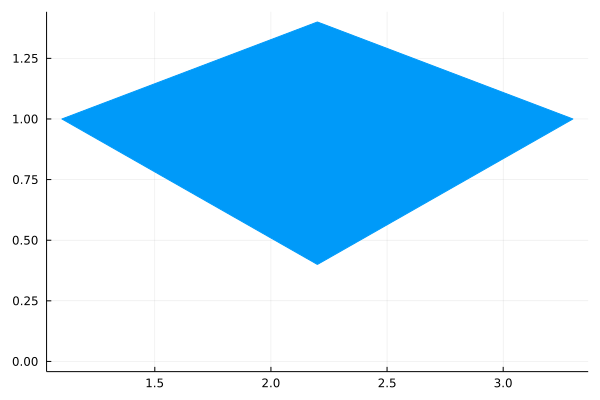

In [42]:
RR.plot()

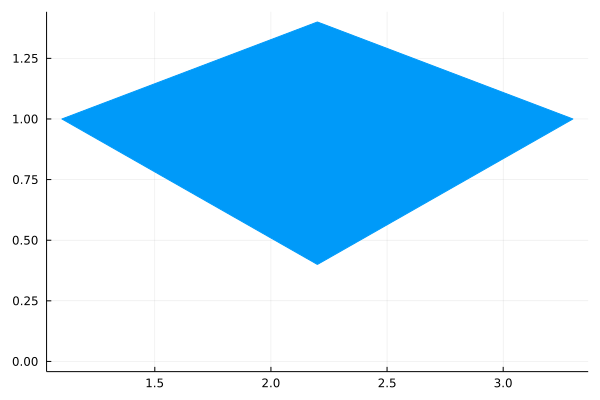

In [43]:
P.plot()

In [45]:
length(R.vertices)

10